# Building Blocks for JAX Implementation

In [1]:
from jax import numpy as jnp
from jax import vmap, jit
from matplotlib import pyplot as plt

from functools import partial

In [ ]:
class NGPHashTable:
    """Single hash table for NGP field.

    References
    ----------
    [1] Muller et al, "Instant Neural Graphics Primitives with a Multiresolution
        Hash Encoding," 2022.
    """

    def __init__(self, size):
        self.size = size

    def hash(self, x):
        """Apply hash function specified by NGP (Eq. 4 [1])"""
        pi2 = 2654435761
        pi3 = 805459861

        return (x[0] + x[1] * pi2 + x[2] * pi3) % self.size

In [9]:
def interpolate(x, grid=None):
    """Trilinear 3D Interpolation; this function is jit and vmap-safe.

    Parameters
    ----------
    x : float[3]
        Coordinates relative to the grid. Should have 0 <= x <= grid.shape.
    grid : callable(int[8, 3]) -> float[nd] or float[nx, ny, nz]
        Grid accessor function; the function is responsible for its own
        vectorization. If passed as just an array, accesses naively.
        The function should return a vector, which is interpolated.

    Returns
    -------
    float
        Scalar interpolated value.
    """
    # 8 corners
    mask = ((
        jnp.arange(8).reshape(-1, 1)
        & jnp.left_shift(1, jnp.arange(3)).reshape(1, -1)
    ) != 0).astype(int)
    # Bound
    bounds = jnp.stack([jnp.floor(x), jnp.ceil(x)]).astype(int)
    # Corner values
    c = bounds[mask, [0, 1, 2]]
    if isinstance(grid, jnp.DeviceArray):
        values = grid[c[:, 0], c[:, 1], c[:, 2]].reshape(8, -1)
    else:
        values = grid(c).reshape(8, -1)
    # Distances from opposite corner (same coord -> make weight 1)
    dist = jnp.abs(bounds[1 - mask, [0, 1, 2]].astype(float) - x)
    dist += (dist == 0)
    # Weights
    weights = jnp.prod(dist, axis=1).reshape(8, -1)
    return jnp.sum(values * weights / jnp.sum(weights), axis=0)

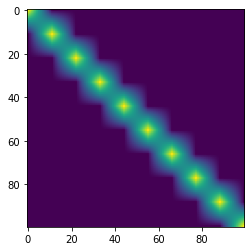

In [13]:
n = 100
grid = jnp.stack([jnp.eye(10).reshape(10, 10, 1) for _ in range(3)])
_x, _y = jnp.meshgrid(jnp.linspace(0, 9, n), jnp.linspace(0, 9, n))
_z = jnp.zeros_like(_y) + 4.5
x = jnp.stack([_z.reshape(-1), _x.reshape(-1), _y.reshape(-1)]).T

res = vmap(partial(interpolate, grid=grid))(x)
plt.imshow(res[:, 0].reshape(n, n))
